In [1]:
!pwd

/home/pczapla/workspace/ulmfit-multilingual/experiments


In [2]:
from fastai.text import *

In [125]:
# unzip task6_test.zip
# unzip task_6-1.zip -d Task6/task\ 01
# unzip task_6-2.zip -d Task6/task\ 02
# mv Task6/task\ 01 task-1
# mv Task6/task\ 02 task-2
# rmdir Task6

SyntaxError: invalid syntax (<ipython-input-125-8e9480cc090e>, line 2)

In [124]:
dataset=Path('../data')/'poleval19'/'task-1'
dataset.ls()

[PosixPath('../data/poleval19/task-1/test_set_clean_only_text.txt'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.txt'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_tags.txt'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.tmp.sid'),
 PosixPath('../data/poleval19/task-1/evaulate1.pl'),
 PosixPath('../data/poleval19/task-1/test_set_clean_only_tags.txt'),
 PosixPath('../data/poleval19/task-1/training_set_clean_only_text.tmp.split')]

In [13]:
LASER = os.environ.get('LASER', "/home/pczapla/workspace/_oss/LASER")
os.environ['LASER'] = LASER
def cond_add_pypath(*paths):
    for path in paths:
        if path not in sys.path:
            sys.path.append(path)
cond_add_pypath(LASER + '/source',LASER + '/source/tools')

from embed import SentenceEncoder, EncodeLoad, EncodeFile
from text_processing import Token, BPEfastApply, SplitLines, JoinEmbed

In [384]:
from subprocess import run, check_output, DEVNULL
def tokenize(inp_fname, out_fname, lang='en',
          lower_case=True, romanize=False, descape=False,
          verbose=False, over_write=False, gzip=False):
    FASTBPE = LASER + '/tools-external/fastBPE/fast'
    MOSES_BDIR = LASER + '/tools-external/moses-tokenizer/tokenizer/'
    MOSES_TOKENIZER = MOSES_BDIR + 'tokenizer.perl -q -no-escape -threads 20 -l '
    MOSES_LC = MOSES_BDIR + 'lowercase.perl'
    NORM_PUNC = MOSES_BDIR + 'normalize-punctuation.perl -l '
    DESCAPE = MOSES_BDIR + 'deescape-special-chars.perl'
    REM_NON_PRINT_CHAR = MOSES_BDIR + 'remove-non-printing-char.perl'

    # Romanization (Greek only)
    ROMAN_LC = 'python3 ' + LASER + '/source/lib/romanize_lc.py -l '

    # Mecab tokenizer for Japanese
    MECAB = LASER + '/tools-external/mecab'
    assert lower_case, 'lower case is needed by all the models'
    if not out_fname.exists():
        cat = 'zcat ' if gzip else 'cat '
        roman = lang if romanize else 'none'
        # handle some iso3 langauge codes
        if lang in ('cmn', 'wuu', 'yue'):
            lang = 'zh'
        if lang in ('jpn'):
            lang = 'ja'
        if verbose:
            print(' - Tokenizer: {} in language {} {} {}'
                  .format(os.path.basename(inp_fname), lang,
                          '(gzip)' if gzip else '',
                          '(de-escaped)' if descape else '',
                          '(romanized)' if romanize else ''))
        cmd = (cat + str(inp_fname)
            + '|' + REM_NON_PRINT_CHAR
            + '|' + NORM_PUNC + lang
            + ('|' + DESCAPE if descape else '')
            + '|' + MOSES_TOKENIZER + lang
            + ('| python3 -m jieba -d ' if lang == 'zh' else '')
            + ('|' + MECAB + '/bin/mecab -O wakati -b 50000 ' if lang == 'ja' else '')
            + ('|' + ROMAN_LC + roman if romanize else '')
            + '>' + str(out_fname))
        print ("Tokenziation CMD: ", cmd)
        run(cmd,
            env=dict(os.environ, LD_LIBRARY_PATH=MECAB + '/lib'),
            shell=True)
    elif not over_write and verbose:
        print(' - Tokenizer: {} exists already'
              .format(os.path.basename(out_fname), lang))


def split_lines(*args): return SplitLines(*list(map(str,args)))
def bpe_fast_apply(*args, **kwargs): return BPEfastApply(*list(map(str,args)), **kwargs)
def encode_file(enc, *args, **kwargs): return EncodeFile(enc, *list(map(str,args)), **kwargs)
def join_embed(*args): return JoinEmbed(*list(map(str,args)))
                      
def process_file(inputfn, lang='pl'):
    inputfn = Path(inputfn)
    args = SimpleNamespace(
        encoder=str(Path(LASER)/"models"/"bilstm.93langs.2018-12-26.pt"), 
        bpe_codes=str(Path(LASER)/"models"/"93langs.fcodes"),
        lang=lang,
        buffer_size=10000,
        max_tokens=12000,
        max_sentences=None,
        cpu=False,
        verbose=False,
        stable=True)
    enc = EncodeLoad(args)
    def fn(suffix):
        return inputfn.with_suffix(f'.tmp{suffix}')
    tokenize(inputfn,
          fn('.tok'),
          lang=lang,
          romanize=(True if lang == 'el' else False),
          lower_case=True, gzip=False,
          verbose=args.verbose, over_write=False)
    bpe_fast_apply(fn('.tok'),
             fn('.bpe'),
             args.bpe_codes,
             verbose=args.verbose, over_write=False)
#     split_lines(fn('.bpe'),
#                fn('.split'),
#                fn('.sid'))
    encode_file(enc,
               fn('.bpe'),
               fn('.enc'),
               verbose=args.verbose, over_write=False,
               buffer_size=args.buffer_size)
#     join_embed(fn('.split.enc'),
#               fn('.sid'),
#               fn('.enc'))
    return fn('.enc')

In [385]:
!rm {dataset}/training_set_clean_only_text.tmp.*
trn_fn = process_file(dataset / 'training_set_clean_only_text.txt')

 - loading encoder /home/pczapla/workspace/_oss/LASER/models/bilstm.93langs.2018-12-26.pt
Tokenziation CMD:  cat ../data/poleval19/task-1/training_set_clean_only_text.txt|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/remove-non-printing-char.perl|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/normalize-punctuation.perl -l pl|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/tokenizer.perl -q -no-escape -threads 20 -l pl>../data/poleval19/task-1/training_set_clean_only_text.tmp.tok


In [386]:
!rm {dataset}/test_set_clean_only_text.tmp.*
tst_fn = process_file(dataset / 'test_set_clean_only_text.txt')

 - loading encoder /home/pczapla/workspace/_oss/LASER/models/bilstm.93langs.2018-12-26.pt
Tokenziation CMD:  cat ../data/poleval19/task-1/test_set_clean_only_text.txt|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/remove-non-printing-char.perl|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/normalize-punctuation.perl -l pl|/home/pczapla/workspace/_oss/LASER/tools-external/moses-tokenizer/tokenizer/tokenizer.perl -q -no-escape -threads 20 -l pl>../data/poleval19/task-1/test_set_clean_only_text.tmp.tok


In [380]:
dim=1024
def read_enc(fn):
    em = np.fromfile(str(fn),dtype=np.float32).reshape(-1, dim)
    return em
read_enc(trn_fn).shape

(10041, 1024)

In [381]:
np.loadtxt(str(dataset/'test_set_clean_only_text.txt'), delimiter='\n', comments=None, dtype=np.str).shape

(1000,)

In [382]:
!wc -l {dataset}/'test_set_clean_only_text.tmp'.*

   1000 ../data/poleval19/task-1/test_set_clean_only_text.tmp.bpe
  13384 ../data/poleval19/task-1/test_set_clean_only_text.tmp.enc
   1241 ../data/poleval19/task-1/test_set_clean_only_text.tmp.sid
   1241 ../data/poleval19/task-1/test_set_clean_only_text.tmp.split
  16667 ../data/poleval19/task-1/test_set_clean_only_text.tmp.split.enc
   1000 ../data/poleval19/task-1/test_set_clean_only_text.tmp.tok
  34533 total


In [387]:
!grep "!" ../data/poleval19/task-1/test_set_clean_only_text.tmp.bpe

@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account I dzięki temu mamy dziś ces@@ ar@@ zo@@ wą .. 😁 😁 😁 . G@@ or@@ ą@@ co pozdra@@ wi@@ am ! 😁 😁 😁
@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account w na@@ gro@@ de wy@@ pi@@ j mój sy@@ ro@@ p ! : D
@ an@@ ony@@ miz@@ ed _ account D@@ ro@@ ga p.@@ K@@ am@@ il@@ ko ! L@@ e@@ czyć się . L@@ e@@ czyć pó@@ ki czas 😁 😁
@ an@@ ony@@ miz@@ ed _ account P@@ ół@@ gł@@ ó@@ we@@ k W@@ i@@ eli@@ ń@@ ski , wy@@ myś@@ li@@ ł sobie pó@@ ł@@ autor@@ y@@ tary@@ z@@ m !
R@@ T @ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account P@@ ół@@ gł@@ ó@@ we@@ k W@@ i@@ eli@@ ń@@ ski , wy@@ myś@@ li@@ ł sobie pó@@ ł@@ autor@@ y@@ tary@@ z@@ m !
@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account N@@ a szczę@@ ście @ an@@ ony@@ miz@@ ed _ account i jego parti@@ a zni@@ kn@@ ą w@@ kró@@ t@@ ce \ n@@ ze scen@@ y politycz@@ nej . B@@ ra@@ wo !
F@@ av albo rt to zrobi@@ ę W@@ am in@@ dy ! ! 

In [390]:
tst_df = pd.DataFrame({
    'y':np.loadtxt(str(dataset/'test_set_clean_only_tags.txt'),delimiter='\n', comments=None, dtype=np.int),
    'em':list(read_enc(tst_fn)), 
    'txt':np.loadtxt(str(dataset/'test_set_clean_only_text.tmp.bpe'), delimiter='\n', comments=None, dtype=np.str),
})

trn_df = pd.DataFrame({
    'y':np.loadtxt(str(dataset/'training_set_clean_only_tags.txt'),delimiter='\n', comments=None, dtype=np.int),
    'em':list(read_enc(trn_fn)), 
    'txt':np.loadtxt(str(dataset/'training_set_clean_only_text.tmp.bpe'), delimiter='\n', comments=None, dtype=np.str),
})




In [391]:
trn_df

,y,em,txt
0,0,"[0.0037167787, -7.2812827e-06, 0.015161359, 0....",D@@ la mnie fa@@ wor@@ y@@ tem do ty@@ tu@@ łu...
1,0,"[0.027270023, 0.0045453347, -0.00034727211, 0....",@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ m...
2,0,"[0.031495534, 0.0047167274, 0.005299656, 0.005...",@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ m...
3,0,"[0.029453455, 0.0029463617, 0.0026986334, 0.00...",@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ m...
4,0,"[0.009985737, -0.0003711908, -0.0012948896, 0....","O@@ dr@@ zut nat@@ ych@@ mi@@ a@@ sto@@ wy , k..."
5,0,"[0.0213333, 0.01625288, 0.0025511486, 0.043600...","J@@ aki on był faj@@ ny x@@ dd pamię@@ tam , ż..."
6,0,"[0.016695889, 0.000779731, 0.0018371007, 0.003...",@ an@@ ony@@ miz@@ ed _ account N@@ o nie ma u...
7,0,"[0.01623468, 0.0043273573, -0.001119913, 0.013...",@ an@@ ony@@ miz@@ ed _ account D@@ aw@@ no ko...
8,0,"[0.028169326, 0.0006355213, 0.0026658343, 0.00...",@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ m...
9,1,"[0.031341758, 0.0028655322, 0.0022675616, 0.00...",@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ m...


In [392]:
tst_df['em'][0]

array([ 0.01389 ,  0.003565, -0.001211,  0.016079, ...,  0.012037,  0.006424,  0.005476,  0.01712 ], dtype=float32)

In [393]:
class EmbeddingText(ItemBase):
    "Basic item for <code>text</code> data in numericalized `ids`."
    def __init__(self, emb, text): self.data,self.text = np.array(emb, dtype=np.float32),text
    def __str__(self):  return str(self.text)

In [394]:
class EmbeddingList(ItemList):
    "Basic `ItemList` for embeding of text data."
    _bunch = DataBunch # TextDataBunch converts input to LongTensor !
    _processor = []

    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)

    def find_text_for_em(self, em):
        # todo find a way to reverse embedding
        return self.inner_df['txt'][1]
        
    def get(self, i):
        o = super().get(i)
        return EmbeddingText(o, self.inner_df['txt'][i])

    def reconstruct(self, t:Tensor):
        return EmbeddingText(t, self.find_text_for_em(t))

    def show_xys(self, xs, ys, max_len:int=70)->None:
        "Show the `xs` (inputs) and `ys` (targets). `max_len` is the maximum number of tokens displayed."
        from IPython.display import display, HTML
        names = ['text','target']
        items = []
        for i, (x,y) in enumerate(zip(xs,ys)):
            txt_x = ' '.join(x.text.split(' ')[:max_len]) if max_len is not None else x.text
            items.append([txt_x, y])
        items = np.array(items)
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False)))

    def show_xyzs(self, xs, ys, zs, max_len:int=70):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions). `max_len` is the maximum number of tokens displayed."
        from IPython.display import display, HTML
        items,names = [],['text','target','prediction']
        for i, (x,y,z) in enumerate(zip(xs,ys,zs)):
            txt_x = ' '.join(x.text.split(' ')[:max_len]) if max_len is not None else x.text
            items.append([txt_x, y, z])
        items = np.array(items)
        df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
        with pd.option_context('display.max_colwidth', -1):
            display(HTML(df.to_html(index=False)))

In [395]:
x[3].data,x[3]

(tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([0, 0, 0,  ..., 0, 0, 0]))

In [396]:
path=dataset/"models"
src = ItemLists(path, 
                EmbeddingList.from_df(trn_df, cols=1, path=path),
                EmbeddingList.from_df(tst_df, cols=1, path=path))
classes=np.unique(trn_df['y'])
src.label_from_lists(trn_df['y'], tst_df['y'], classes=classes, processor=[])
data = src.databunch()

In [397]:
data.show_batch()

text,target
@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account B@@ ra@@ wo ty D@@ aria ki@@ bi@@ c ma być na dobre i zł@@ e,0
@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account B@@ ra@@ wo ty D@@ aria ki@@ bi@@ c ma być na dobre i zł@@ e,1
@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account B@@ ra@@ wo ty D@@ aria ki@@ bi@@ c ma być na dobre i zł@@ e,0
@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account B@@ ra@@ wo ty D@@ aria ki@@ bi@@ c ma być na dobre i zł@@ e,0
@ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account B@@ ra@@ wo ty D@@ aria ki@@ bi@@ c ma być na dobre i zł@@ e,0


In [398]:
class LaserSentCLS(nn.Module):
    def __init__(self, idim=1024, odim=2, nhid=None,
                 dropout=0.0, activation='TANH'):
        super().__init__()
        modules = []

        modules = []
        print(' - mlp {:d}'.format(idim), end='')
        if len(nhid) > 0:
            if dropout > 0:
                modules.append(nn.Dropout(p=dropout))
            nprev = idim
            for nh in nhid:
                if nh > 0:
                    modules.append(nn.Linear(nprev, nh))
                    nprev = nh
                    if activation == 'TANH':
                        modules.append(nn.Tanh())
                        print('-{:d}t'.format(nh), end='')
                    elif activation == 'RELU':
                        modules.append(nn.ReLU())
                        print('-{:d}r'.format(nh), end='')
                    else:
                       raise Exception('Unrecognized activation {activation}')
                    if dropout > 0:
                        modules.append(nn.Dropout(p=dropout))
            modules.append(nn.Linear(nprev, odim))
            print('-{:d}, dropout={:.1f}'.format(odim, dropout))
        else:
            modules.append(nn.Linear(idim, odim))
            print(' - mlp %d-%d'.format(idim, odim))
        self.mlp = nn.Sequential(*modules)
    def forward(self, x):
        return self.mlp(x)

In [431]:
m=LaserSentCLS(nhid=[10, 8])

 - mlp 1024-10t-8t-2, dropout=0.0


In [432]:
learn = Learner(data, m, metrics=[accuracy, FBeta(beta=1, average='binary')])

In [433]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


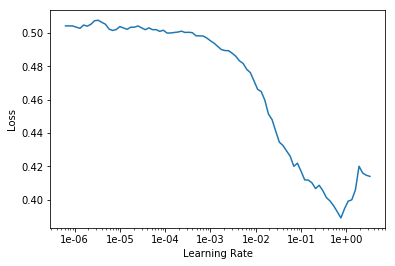

In [434]:
learn.recorder.plot()

In [436]:
learn.fit(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.293952,0.414809,0.866000,0.000000,00:01
1,0.287149,0.427415,0.866000,0.000000,00:01
2,0.287002,0.419744,0.866000,0.000000,00:01
3,0.285750,0.405203,0.866000,0.000000,00:01
4,0.290238,0.401495,0.866000,0.000000,00:01
5,0.226587,0.332613,0.866000,0.000000,00:01
6,0.218588,0.288291,0.880000,0.294118,00:01
7,0.202024,0.355967,0.872000,0.123288,00:01
8,0.196263,0.319612,0.873000,0.147651,00:01
9,0.196639,0.315491,0.878000,0.227848,00:01


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)


In [ ]:
interp.plot_confusion_matrix()

In [463]:
learn.save("best-45")

In [439]:
l, i = interp.top_losses()

In [446]:
interp.confusion_matrix()

array([[836,  30],
       [ 86,  48]])

In [461]:
neutral_as_offensive = np.nonzero((interp.pred_class != interp.y_true) & (interp.y_true == 0)).reshape(-1)

In [462]:
for ix in neutral_as_offensive: print(data.valid_ds[ix])

(EmbeddingText P@@ ro@@ wad@@ zą@@ cy mówi ze nikt mu nie wy@@ s@@ ła@@ ł sz@@ ki@@ ców projekt@@ ów jak nie jak ja ci wy@@ sł@@ ałam im@@ be@@ cy@@ lu, Category 0)
(EmbeddingText @ an@@ ony@@ miz@@ ed _ account T@@ ak@@ ie P@@ ol@@ ska - N@@ iem@@ cy na N@@ ar@@ odo@@ wym 😜, Category 0)
(EmbeddingText K@@ U@@ P@@ I@@ Ł@@ A@@ M P@@ I@@ E@@ R@@ W@@ S@@ Z@@ E A@@ U@@ T@@ K@@ O J@@ A@@ K K@@ T@@ O@@ Ś C@@ H@@ C@@ E Z@@ D@@ J@@ Ę@@ C@@ I@@ E T@@ O M@@ O@@ G@@ Ę W@@ Y@@ S@@ Ł@@ A@@ Ć N@@ A D@@ M J@@ E@@ S@@ T@@ E@@ M : W M@@ I@@ Ł@@ O@@ Ś@@ C@@ I, Category 0)
(EmbeddingText @ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account 100 osób + / -@@ 5 sal@@ kan@@ w sam raz , każ@@ da kolej@@ na oso@@ ba to ś@@ cis@@ k 😂 😂 😂, Category 0)
(EmbeddingText G@@ dzie jest m@@ ę@@ dre@@ k z m@@ ę@@ dr@@ ko@@ wa @ an@@ ony@@ miz@@ ed _ account ?, Category 0)
(EmbeddingText @ an@@ ony@@ miz@@ ed _ account O@@ d@@ powiedz jest pro@@ sta \ n@@ B@@ o to N@@ iem@@ cy a my P@@ ol@@ ska nie eleg@@ an@@

In [442]:
for ix in range(0,10): print(data.valid_ds[i[ix]])

(EmbeddingText T@@ ym których nie było na me@@ cz@@ u ze względu na koniec zgo@@ dy mam kilka sł@@ ów do prze@@ kazan@@ ia@@ .@@ W@@ y@@ pier@@ d@@ ala@@ ć do W@@ ro@@ c@@ ła@@ wia albo G@@ da@@ ń@@ ska, Category 1)
(EmbeddingText @ an@@ ony@@ miz@@ ed _ account C@@ h@@ ci@@ ał@@ byś aby tak było mier@@ no@@ to : ), Category 1)
(EmbeddingText J@@ eba@@ c chu@@ ju , lew@@ us@@ ów , nikt mi nie bron@@ il ale to przes@@ ada, Category 1)
(EmbeddingText @ an@@ ony@@ miz@@ ed _ account @ an@@ ony@@ miz@@ ed _ account N@@ iest@@ ety nie og@@ lą@@ da@@ łem . A@@ le jedna rzecz w tym po@@ ście jest nie@@ prawdzi@@ wa . Ż@@ al@@ ek i wied@@ za to dwa wy@@ klu@@ cza@@ jące się by@@ ty, Category 1)
(EmbeddingText @ an@@ ony@@ miz@@ ed _ account A kto tra@@ ktu@@ je poważ@@ nie ten sz@@ mat@@ ła@@ wie@@ c ? ?, Category 1)
(EmbeddingText @ an@@ ony@@ miz@@ ed _ account P@@ ani się dobrze za@@ stanowi co robi@@ cie . T@@ e@@ ż ma@@ cie bi@@ ura , sam@@ och@@ ody , dom@@ y , dzieci , w@@ nu@@ ki it@@ 